# Plot 3D results nicely

In [20]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits
# %matplotlib widget


In [21]:
CFIS_pattern = 'validation_psf-{:07d}-38.fits'

def plot_ell(my_path, file_pattern = 'validation_psf-38-{:06d}.fits', n_starcats = 453, n_test_stars = 10):

    e1_stars = np.zeros((n_test_stars,n_starcats))
    e1_psfs = np.zeros((n_test_stars,n_starcats))
    e2_stars = np.zeros((n_test_stars,n_starcats))
    e2_psfs = np.zeros((n_test_stars,n_starcats))


    for k in range(n_starcats):
        model = fits.open(my_path + file_pattern.format(k))
        e1_stars[:,k] = model[2].data['E1_STAR_HSM']
        e1_psfs[:,k] = model[2].data['E1_PSF_HSM']
        e2_stars[:,k] = model[2].data['E2_STAR_HSM']
        e2_psfs[:,k] = model[2].data['E2_PSF_HSM']
        model.close()
    model = fits.open(my_path + file_pattern.format(0))
    X = model[2].data['X']
    Y = model[2].data['Y']
    model.close()

    e1_star_mean = np.mean(e1_stars, axis = 1)
    e1_star_med = np.median(e1_stars, axis = 1)
    e1_star_std = np.std(e1_stars, axis = 1)
    e2_star_mean = np.mean(e2_stars, axis = 1)
    e2_star_med = np.median(e2_stars, axis = 1)
    e2_star_std = np.std(e2_stars, axis = 1)

    e1_psf_mean = np.mean(e1_psfs, axis = 1)
    e1_psf_med = np.median(e1_psfs, axis = 1)
    e1_psf_std = np.std(e1_psfs, axis = 1)
    e2_psf_mean = np.mean(e2_psfs, axis = 1)
    e2_psf_med = np.median(e2_psfs, axis = 1)
    e2_psf_std = np.std(e2_psfs, axis = 1)
    
    e1_err = e1_star_mean - e1_psf_mean
    e2_err = e2_star_mean - e2_psf_mean
    

    x_min = (np.max(X) + np.min(X) - max(np.max(X) - np.min(X), np.max(Y) - np.min(Y))) / 2
    x_max = (np.max(X) + np.min(X) + max(np.max(X) - np.min(X), np.max(Y) - np.min(Y))) / 2
    y_min = (np.max(Y) + np.min(Y) - max(np.max(X) - np.min(X), np.max(Y) - np.min(Y))) / 2
    y_max = (np.max(Y) + np.min(Y) + max(np.max(X) - np.min(X), np.max(Y) - np.min(Y))) / 2

    fig = plt.figure()
    fig.set_figheight(10)
    #fig.set_figwidth(10)
    
    ax = fig.add_subplot(211, projection = '3d')
    ax.set_xlim3d(x_min, x_max)
    ax.set_ylim3d(y_min, y_max)
    ax.scatter(X, Y, e1_star_mean)
    ax.scatter(X, Y, e1_psf_mean)
    ax.title.set_text('e1')
    plt.show()
    
    #fig2 = plt.figure()
    ax2 = fig.add_subplot(212, projection = '3d')
    ax2.set_xlim3d(x_min, x_max)
    ax2.set_ylim3d(y_min, y_max)
    ax2.scatter(X, Y, e2_star_mean)
    ax2.scatter(X, Y, e2_psf_mean)
    ax2.title.set_text('e2')
    plt.show()
    
    return e1_err, e2_err, X, Y



def plot_color2d(mat1,mat2,save_path):
    # Plot matrices into a color 2D map
    """
    import matplotlib as mpl
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    """  
    
    # Calculate errors
    idx1, idx2 = np.nonzero(mat1)
    RMSE_e1 = rmse(mat1[idx1, idx2])
    
    idx1, idx2 = np.nonzero(mat2)
    RMSE_e2 = rmse(mat2[idx1, idx2])
    
    # Define the color map to be used
    top = mpl.cm.get_cmap('Oranges_r', 128)
    bottom = mpl.cm.get_cmap('Blues', 128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')
    
    # Generate figure
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    
    vmax1 = 0.01 # e1 resolution
    vmax2 = 0.002 # e2 resolution
    
    # First subplot
    #vmax1 = np.max([abs(np.max(mat1)), abs(np.min(mat1))])
    psm = axs[0].pcolormesh(mat1.T, cmap=newcmp, rasterized=True, vmin = -vmax1, vmax = vmax1)
    axs[0].title.set_text('e1 error')
    fig.colorbar(psm, ax=axs[0])
    axs[0].set_xlabel('x \n RMSE: ' + "%.6f"%RMSE_e1)
    axs[0].set_ylabel('y')
    
    # Second subplot
    # vmax2 = np.max([abs(np.max(mat2)), abs(np.min(mat2))])
    psm = axs[1].pcolormesh(mat2.T, cmap=newcmp, rasterized=True, vmin = -vmax2, vmax = vmax2)
    axs[1].title.set_text('e2 error')
    fig.colorbar(psm, ax=axs[1])
    axs[1].set_xlabel('x \n RMSE: ' + "%.6f"%RMSE_e2)
    axs[1].set_ylabel('y')
    
    plt.show()
    plt.savefig(save_path)
    
    
    
def gen_err_mat(err_vec_1, err_vec_2, X, Y):
    # Generate the error matrix from the error vector
    # accounting for its position on the grid
    X_unique = np.load('X_unique.npy')
    Y_unique = np.load('Y_unique.npy')
    x_len = len(X_unique)
    y_len = len(Y_unique)

    e1_mat = np.zeros((x_len,y_len))
    e2_mat = np.zeros((x_len,y_len))

    for it in range(len(X)):
        x_idx = np.where(X_unique == X[it])[0][0]
        y_idx = np.where(Y_unique == Y[it])[0][0]

        e1_mat[x_idx,y_idx] = err_vec_1[it]
        e2_mat[x_idx,y_idx] = err_vec_2[it]
        
    return e1_mat, e2_mat

def rmse(vec):
    return np.sqrt(np.mean(vec ** 2))

<IPython.core.display.Javascript object>


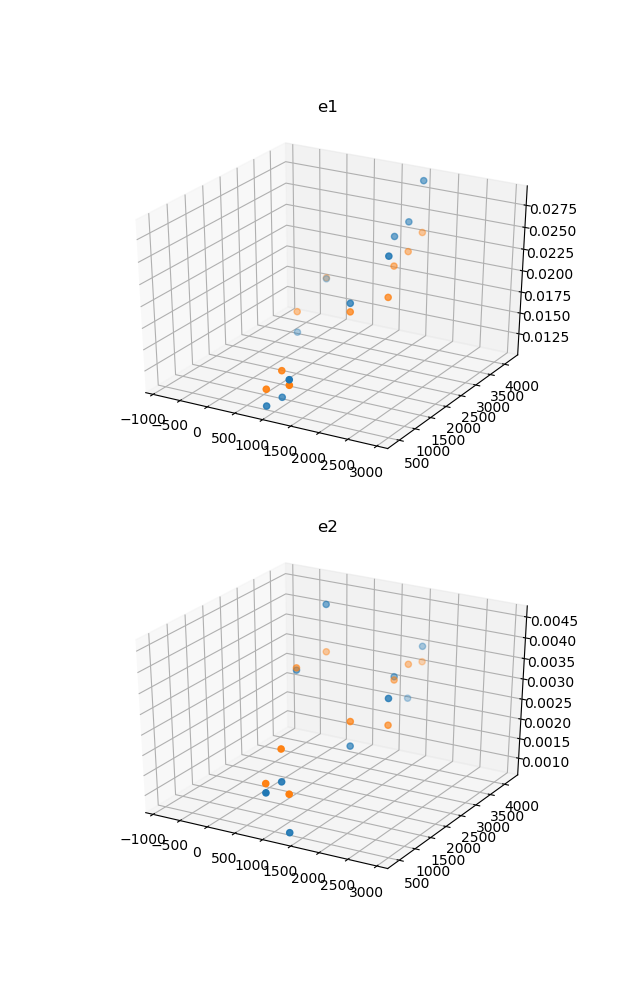

<IPython.core.display.Javascript object>


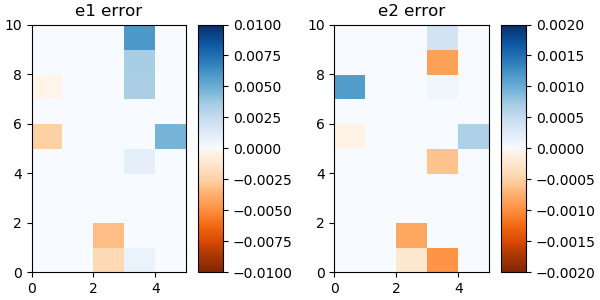

"\nmy_path_test2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_validation/test-2/rca_runner/output/'\ne1_err_test2, e2_err_test2 = plot_ell(my_path_test2)\nmy_path_test3 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_validation/test-3/rca_runner/output/'\ne1_err_test3, e2_err_test3 = plot_ell(my_path_test3)\n"

In [158]:
# Plot 3D maps
my_path_test1 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_validation/test-3/rca_runner/output/'
e1_err_test1, e2_err_test1, X, Y = plot_ell(my_path_test1)

# Plot 2D maps
e1_mat,e2_mat = gen_err_mat(e1_err_test1, e2_err_test1, X, Y)
plot_color2d(e1_mat,e2_mat,'2d-plot-test3.png')


"""
my_path_test2 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_validation/test-2/rca_runner/output/'
e1_err_test2, e2_err_test2 = plot_ell(my_path_test2)
my_path_test3 = '/Users/tliaudat/Documents/PhD/codes/venv_p3/tests/output_validation/test-3/rca_runner/output/'
e1_err_test3, e2_err_test3 = plot_ell(my_path_test3)
"""

# JB tests

In [22]:
JB_test1_path = '/Users/mschmitz/jbonnin/Data/rca_runs/w3/shapepipe_run_2019-12-03_11-18-29/rca_runner/output/'
JB_test2_path = '/Users/mschmitz/jbonnin/Data/rca_runs/w3/shapepipe_run_2019-12-03_11-20-30/rca_runner/output/'
JB_test3_path = '/Users/mschmitz/jbonnin/Data/rca_runs/w3/shapepipe_run_2019-11-29_10-58-58/rca_runner/output/'
JB_test4_path = '/Users/mschmitz/jbonnin/Data/rca_runs/w3/shapepipe_run_2019-12-02_11-26-43/rca_runner/output/'

## JB test 1

CCD 38

sigma_noise = 1e-3

**4 eigenPSFs**

<IPython.core.display.Javascript object>


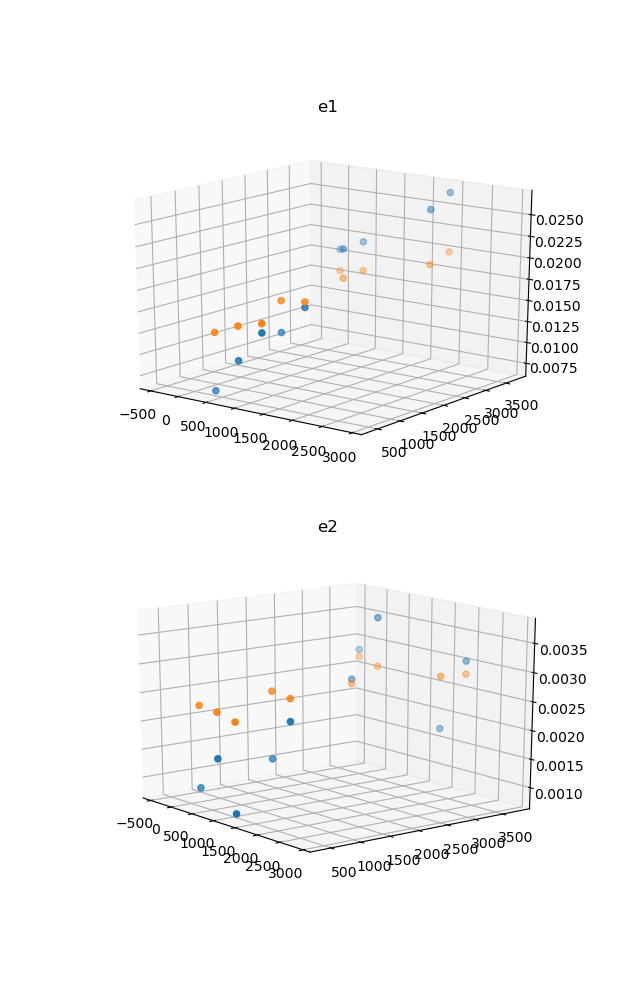

<IPython.core.display.Javascript object>


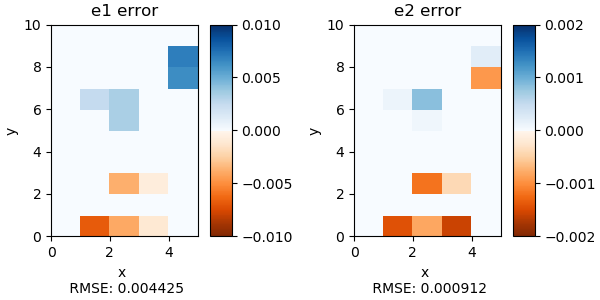

In [23]:
e1_err_1, e2_err_1, X, Y = plot_ell(JB_test1_path, file_pattern = CFIS_pattern)
e1_mat_1, e2_mat_1 = gen_err_mat(e1_err_1, e2_err_1, X, Y)
plot_color2d(e1_mat_1, e2_mat_1, 'JB_test1.png')

## JB test 2

CCD 38

sigma_noise = 1e-3

**8 eigenPSFs**

<IPython.core.display.Javascript object>


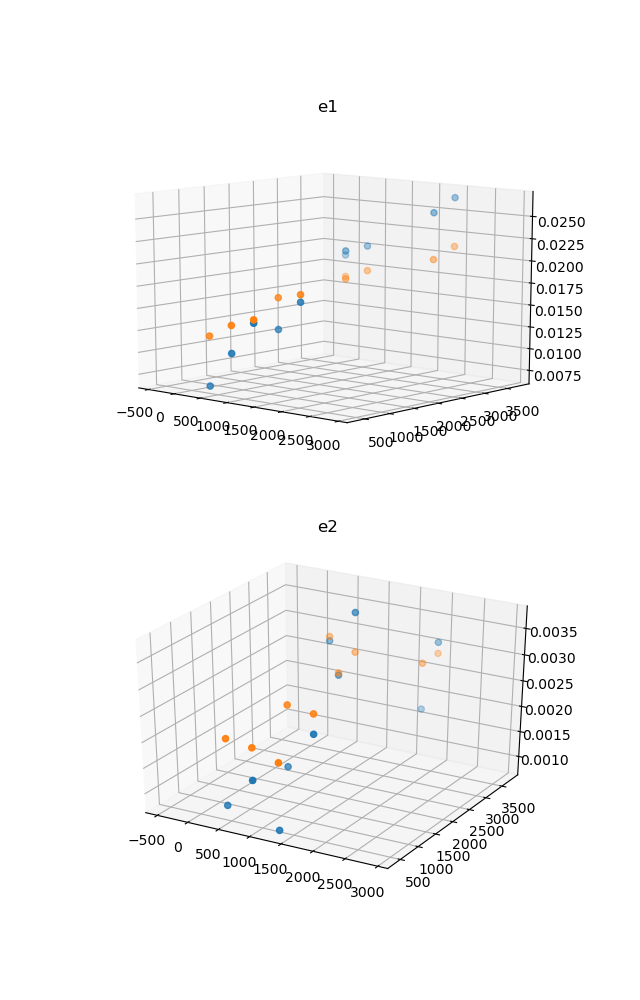

<IPython.core.display.Javascript object>


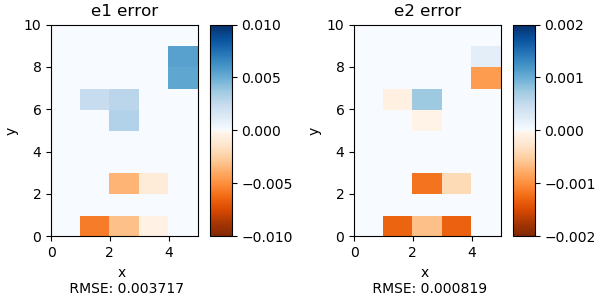

In [24]:
e1_err_2, e2_err_2, X, Y = plot_ell(JB_test2_path, file_pattern = CFIS_pattern)
e1_mat_2, e2_mat_2 = gen_err_mat(e1_err_2, e2_err_2, X, Y)
plot_color2d(e1_mat_2, e2_mat_2, 'JB_test2.png')

## JB test 3

CCD 38

sigma_noise = 1e-3

**16 eigenPSFs**

<IPython.core.display.Javascript object>


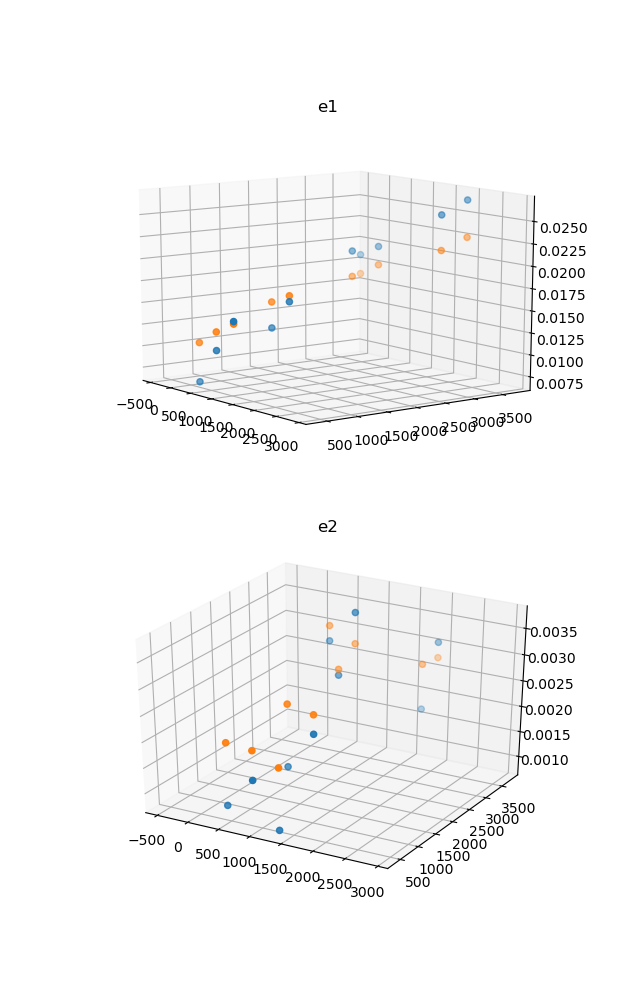

<IPython.core.display.Javascript object>


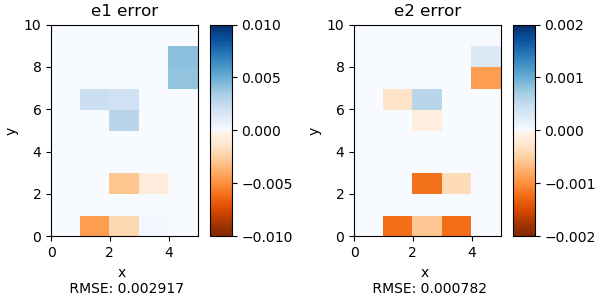

In [25]:
e1_err_3, e2_err_3, X, Y = plot_ell(JB_test3_path, file_pattern = CFIS_pattern)
e1_mat_3, e2_mat_3 = gen_err_mat(e1_err_3, e2_err_3, X, Y)
plot_color2d(e1_mat_3, e2_mat_3, 'JB_test3.png')

## JB test 4

CCD 38

sigma_noise = 1e-3

**32 eigenPSFs**

<IPython.core.display.Javascript object>


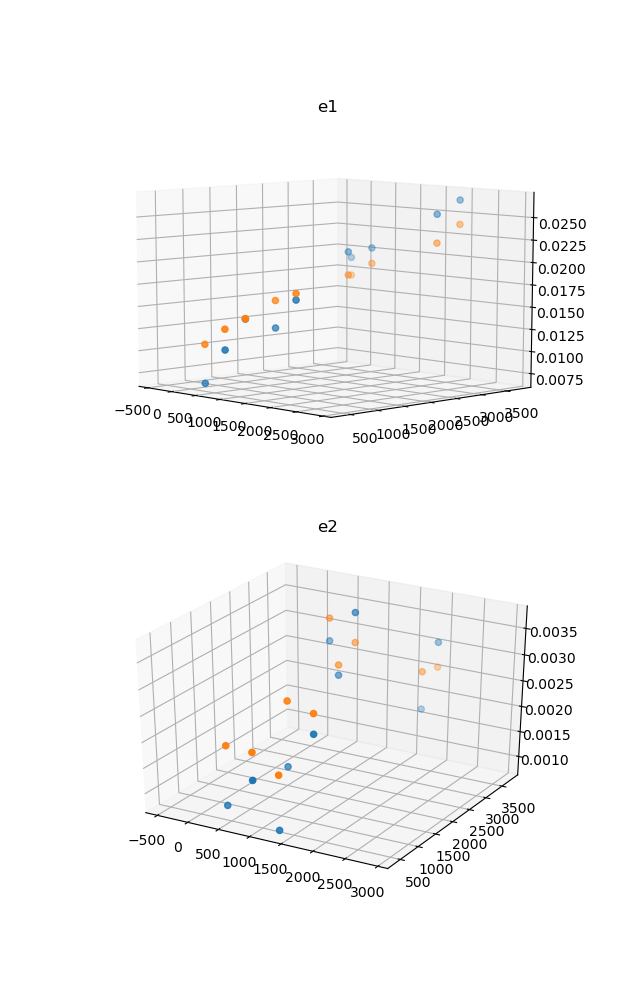

<IPython.core.display.Javascript object>


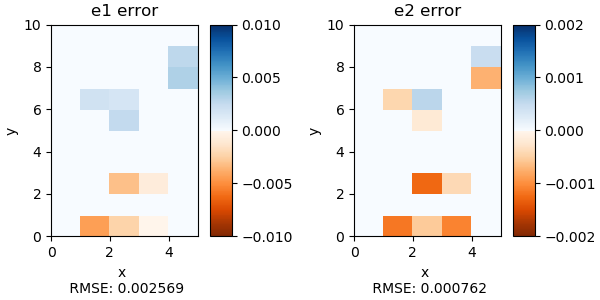

In [26]:
e1_err_4, e2_err_4, X, Y = plot_ell(JB_test4_path, file_pattern = CFIS_pattern)
e1_mat_4, e2_mat_4 = gen_err_mat(e1_err_4, e2_err_4, X, Y)
plot_color2d(e1_mat_4, e2_mat_4, 'JB_test4.png')